# Week 1: Adam/AdamW

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import List, Tuple
import numpy as np

## Adam vs AdamW Implementation

In [ ]:
class Adam:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            if p.grad is None: continue
            g = p.grad.data
            if self.weight_decay > 0:
                g = g + self.weight_decay * p.data  # Coupled
            self.m[i] = self.betas[0] * self.m[i] + (1 - self.betas[0]) * g
            self.v[i] = self.betas[1] * self.v[i] + (1 - self.betas[1]) * g * g
            m_hat = self.m[i] / (1 - self.betas[0]**self.t)
            v_hat = self.v[i] / (1 - self.betas[1]**self.t)
            update = m_hat / (torch.sqrt(v_hat) + self.eps)
            p.data -= self.lr * update

class AdamW:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0
    
    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            if p.grad is None: continue
            g = p.grad.data
            if self.weight_decay > 0:
                p.data -= self.lr * self.weight_decay * p.data  # Decoupled
            self.m[i] = self.betas[0] * self.m[i] + (1 - self.betas[0]) * g
            self.v[i] = self.betas[1] * self.v[i] + (1 - self.betas[1]) * g * g
            m_hat = self.m[i] / (1 - self.betas[0]**self.t)
            v_hat = self.v[i] / (1 - self.betas[1]**self.t)
            update = m_hat / (torch.sqrt(v_hat) + self.eps)
            p.data -= self.lr * update

## Training Loop + Comparison

In [3]:
# ==================== 1. Tiny Transformer Model ====================
class TinyTransformer(nn.Module):
    def __init__(self, vocab_size=10, d_model=32, nhead=4, num_layers=2, seq_len=10):
        super().__init__()
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        
        # Token embedding
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional encoding (learnable)
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, d_model) * 0.1)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=128, 
            dropout=0.0,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output = nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        # x shape: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Token embedding + positional encoding
        embedded = self.embedding(x)  # [batch, seq_len, d_model]
        embedded = embedded + self.pos_encoding[:, :x.shape[1], :]
        
        # Transformer processing
        transformed = self.transformer(embedded)  # [batch, seq_len, d_model]
        
        # Predict next character
        logits = self.output(transformed)  # [batch, seq_len, vocab_size]
        
        return logits

# ==================== 2. Simplified MLP Model (Faster Alternative) ====================
class TinyMLP(nn.Module):
    """Simpler MLP model for faster experimentation"""
    def __init__(self, vocab_size=10, hidden_size=64, seq_len=10):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size * seq_len, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size * seq_len)
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        
    def forward(self, x):
        # x shape: [batch_size, seq_len]
        batch_size = x.shape[0]
        
        # Embedding layer
        embedded = self.embedding(x)  # [batch, seq_len, hidden]
        embedded = embedded.view(batch_size, -1)  # Flatten: [batch, seq_len*hidden]
        
        # MLP processing
        hidden = torch.relu(self.fc1(embedded))
        output = self.fc2(hidden)
        
        # Reshape back to sequence format
        output = output.view(batch_size, self.seq_len, self.vocab_size)
        
        return output

# ==================== 3. Synthetic Data Generation Function ====================
def generate_toy_data(batch_size=32, seq_len=10, vocab_size=10, device='cpu'):
    """
    Generate simple sequence prediction data:
    Input: random sequence
    Target: input sequence rotated left by one position (simple sequence prediction task)
    """
    # Generate random sequence
    x = torch.randint(0, vocab_size, (batch_size, seq_len), device=device)
    
    # Target: rotate left by one position, fill last position with first character
    y = torch.zeros_like(x)
    y[:, :-1] = x[:, 1:]  # Shift left by one
    y[:, -1] = x[:, 0]    # Fill last position with first character
    
    return x, y

# ==================== 4. Training Function ====================
def train(model: nn.Module, 
          optimizer_class: type, 
          steps: int = 3000, 
          wd: float = 0.01,
          use_mlp: bool = False,  # Use faster MLP
          batch_size: int = 32,
          device: str = 'cuda' if torch.cuda.is_available() else 'cpu') -> Tuple[List[float], List[float]]:
    """
    Training function to compare optimizers
    
    Args:
        model: Model to train
        optimizer_class: Optimizer class (e.g., Adam or AdamW)
        steps: Number of training steps
        wd: Weight decay coefficient
        use_mlp: Whether to use MLP instead of Transformer
        batch_size: Batch size for training
        device: Training device (CPU or CUDA)
        
    Returns:
        losses: List of loss values per step
        param_norms: List of parameter L2 norms per step
    """
    
    # Move model to device
    model = model.to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Create optimizer with specified weight decay
    optimizer = optimizer_class(model.parameters(), lr=1e-3, weight_decay=wd)
    
    # Storage for training history
    losses = []
    param_norms = []
    
    # Training loop
    model.train()
    for step in range(steps):
        # Generate synthetic data for this batch
        inputs, targets = generate_toy_data(
            batch_size=batch_size, 
            seq_len=model.seq_len if hasattr(model, 'seq_len') else 10,
            vocab_size=model.vocab_size if hasattr(model, 'vocab_size') else 10,
            device=device
        )
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Compute loss (flatten sequences for cross-entropy)
        loss = criterion(outputs.view(-1, outputs.shape[-1]), targets.view(-1))
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping (prevent exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimization step
        optimizer.step()
        
        # Record loss
        losses.append(loss.item())
        
        # Compute parameter L2 norm (without gradients)
        with torch.no_grad():
            norm = 0
            for p in model.parameters():
                if p.data is not None:
                    norm += torch.sum(p.data ** 2).item()
            param_norms.append(norm ** 0.5)  # Store sqrt (actual L2 norm)
        
        # Print progress every 500 steps
        if step % 500 == 0:
            print(f'Step {step}/{steps}, Loss: {loss.item():.4f}, Param Norm: {param_norms[-1]:.4f}')
    
    # Final statistics
    print(f'Final - Loss: {losses[-1]:.4f}, Param Norm: {param_norms[-1]:.4f}')
    
    return losses, param_norms

# ==================== 5. Visualization Function ====================
def plot_results(adam_losses, adam_norms, adamw_losses, adamw_norms, wd_value=0.01):
    """Plot training results comparison"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Loss curves
    axes[0, 0].plot(adam_losses, label=f'Adam (wd={wd_value})', alpha=0.7)
    axes[0, 0].set_title('Adam Loss Curve')
    axes[0, 0].set_xlabel('Training Steps')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(adamw_losses, label=f'AdamW (wd={wd_value})', color='orange', alpha=0.7)
    axes[0, 1].set_title('AdamW Loss Curve')
    axes[0, 1].set_xlabel('Training Steps')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Parameter norm curves
    axes[1, 0].plot(adam_norms, label=f'Adam (wd={wd_value})', alpha=0.7)
    axes[1, 0].set_title('Adam Parameter Norm')
    axes[1, 0].set_xlabel('Training Steps')
    axes[1, 0].set_ylabel('L2 Norm of Parameters')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(adamw_norms, label=f'AdamW (wd={wd_value})', color='orange', alpha=0.7)
    axes[1, 1].set_title('AdamW Parameter Norm')
    axes[1, 1].set_xlabel('Training Steps')
    axes[1, 1].set_ylabel('L2 Norm of Parameters')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==================== 6. Comparative Experiment Function ====================
def run_experiment(wd_values=[0.0, 0.01, 0.1], steps=2000, use_mlp=True):
    """
    Run comparative experiments with different weight decay values
    
    Args:
        wd_values: List of weight decay values to test
        steps: Training steps per experiment
        use_mlp: Whether to use MLP (faster) or Transformer
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    results = {}
    
    for wd in wd_values:
        print(f"\n{'='*60}")
        print(f"Running experiment with weight_decay={wd}")
        print('='*60)
        
        # Reset random seeds for fair comparison
        torch.manual_seed(42)
        np.random.seed(42)
        
        # Create two identical models
        if use_mlp:
            model_adam = TinyMLP(vocab_size=10, hidden_size=64, seq_len=10)
            model_adamw = TinyMLP(vocab_size=10, hidden_size=64, seq_len=10)
        else:
            model_adam = TinyTransformer(vocab_size=10, d_model=32, nhead=4, num_layers=2, seq_len=10)
            model_adamw = TinyTransformer(vocab_size=10, d_model=32, nhead=4, num_layers=2, seq_len=10)
        
        # Train with different optimizers
        print("\nTraining with Adam...")
        adam_losses, adam_norms = train(model_adam, torch.optim.Adam, 
                                        steps=steps, wd=wd, use_mlp=use_mlp, device=device)
        
        print("\nTraining with AdamW...")
        adamw_losses, adamw_norms = train(model_adamw, torch.optim.AdamW, 
                                          steps=steps, wd=wd, use_mlp=use_mlp, device=device)
        
        # Store results
        results[wd] = {
            'adam_losses': adam_losses,
            'adam_norms': adam_norms,
            'adamw_losses': adamw_losses,
            'adamw_norms': adamw_norms
        }
        
        # Plot comparison
        plot_results(adam_losses, adam_norms, adamw_losses, adamw_norms, wd)
        
        # Print final statistics
        print(f"\nFinal Results for wd={wd}:")
        print(f"Adam  - Final Loss: {adam_losses[-1]:.4f}, Final Norm: {adam_norms[-1]:.4f}")
        print(f"AdamW - Final Loss: {adamw_losses[-1]:.4f}, Final Norm: {adamw_norms[-1]:.4f}")
    
    return results

# ==================== 7. Quick Test Function ====================
def quick_test():
    """Quick test with single configuration"""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Create models
    model_adam = TinyMLP(vocab_size=10, hidden_size=64, seq_len=10)
    model_adamw = TinyMLP(vocab_size=10, hidden_size=64, seq_len=10)
    
    # Train both models
    print("Training Adam...")
    adam_losses, adam_norms = train(model_adam, torch.optim.Adam, 
                                    steps=2000, wd=0.01, use_mlp=True, device=device)
    
    print("\nTraining AdamW...")
    adamw_losses, adamw_norms = train(model_adamw, torch.optim.AdamW, 
                                      steps=2000, wd=0.01, use_mlp=True, device=device)
    
    # Visualize results
    plot_results(adam_losses, adam_norms, adamw_losses, adamw_norms, wd_value=0.01)
    
    return adam_losses, adam_norms, adamw_losses, adamw_norms

Training Adam...
Step 0/2000, Loss: 2.3355, Param Norm: 26.7545
Step 500/2000, Loss: 0.3722, Param Norm: 21.2066
Step 1000/2000, Loss: 0.3892, Param Norm: 18.1563
Step 1500/2000, Loss: 0.3784, Param Norm: 17.0262
Final - Loss: 0.3864, Param Norm: 16.6138

Training AdamW...
Step 0/2000, Loss: 2.3212, Param Norm: 25.4807
Step 500/2000, Loss: 0.0212, Param Norm: 32.9451
Step 1000/2000, Loss: 0.0063, Param Norm: 34.8150
Step 1500/2000, Loss: 0.0060, Param Norm: 35.8588
Final - Loss: 0.0020, Param Norm: 36.5951


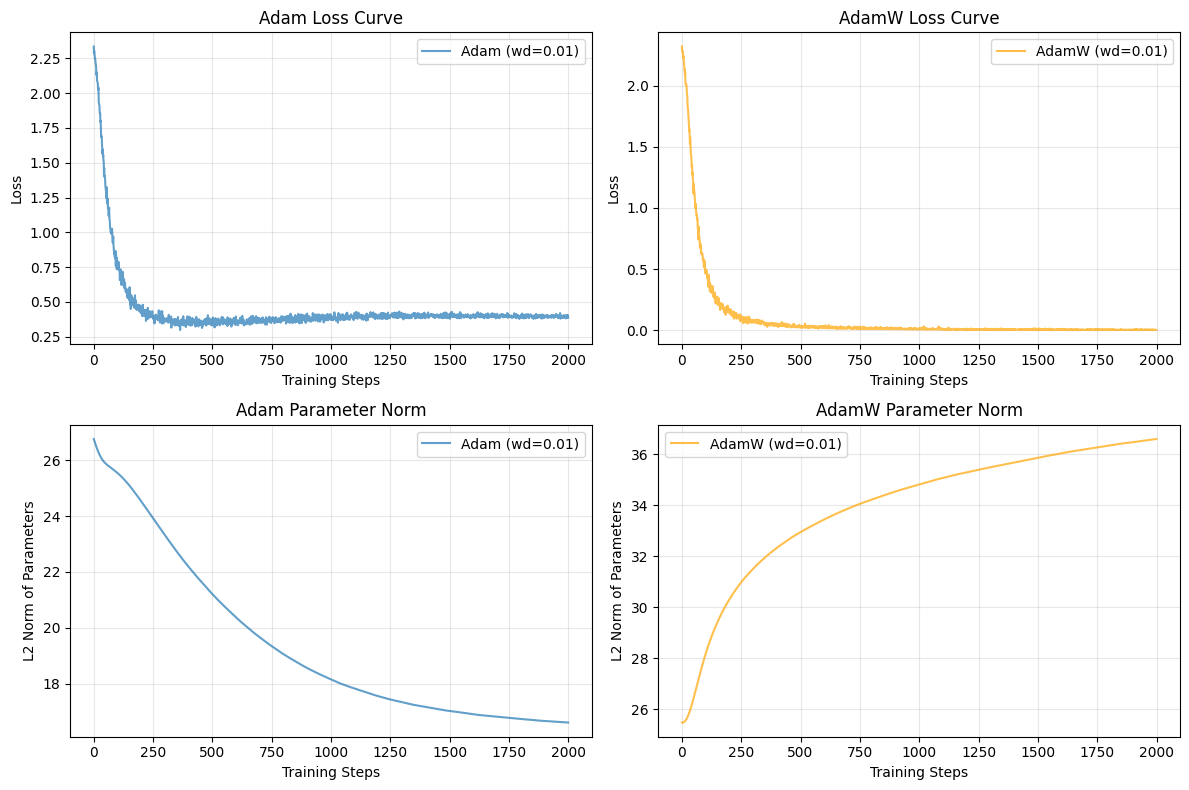

In [4]:
# Option 1: Quick test (recommended)
adam_losses, adam_norms, adamw_losses, adamw_norms = quick_test()

Using device: cuda

Running experiment with weight_decay=0.0

Training with Adam...
Step 0/2000, Loss: 2.3511, Param Norm: 25.8959
Step 500/2000, Loss: 0.0291, Param Norm: 33.5457
Step 1000/2000, Loss: 0.0094, Param Norm: 35.5704
Step 1500/2000, Loss: 0.0024, Param Norm: 36.7779
Final - Loss: 0.0025, Param Norm: 37.5802

Training with AdamW...
Step 0/2000, Loss: 2.3471, Param Norm: 27.3242
Step 500/2000, Loss: 0.0314, Param Norm: 34.5695
Step 1000/2000, Loss: 0.0119, Param Norm: 36.5326
Step 1500/2000, Loss: 0.0029, Param Norm: 37.6992
Final - Loss: 0.0033, Param Norm: 38.5463


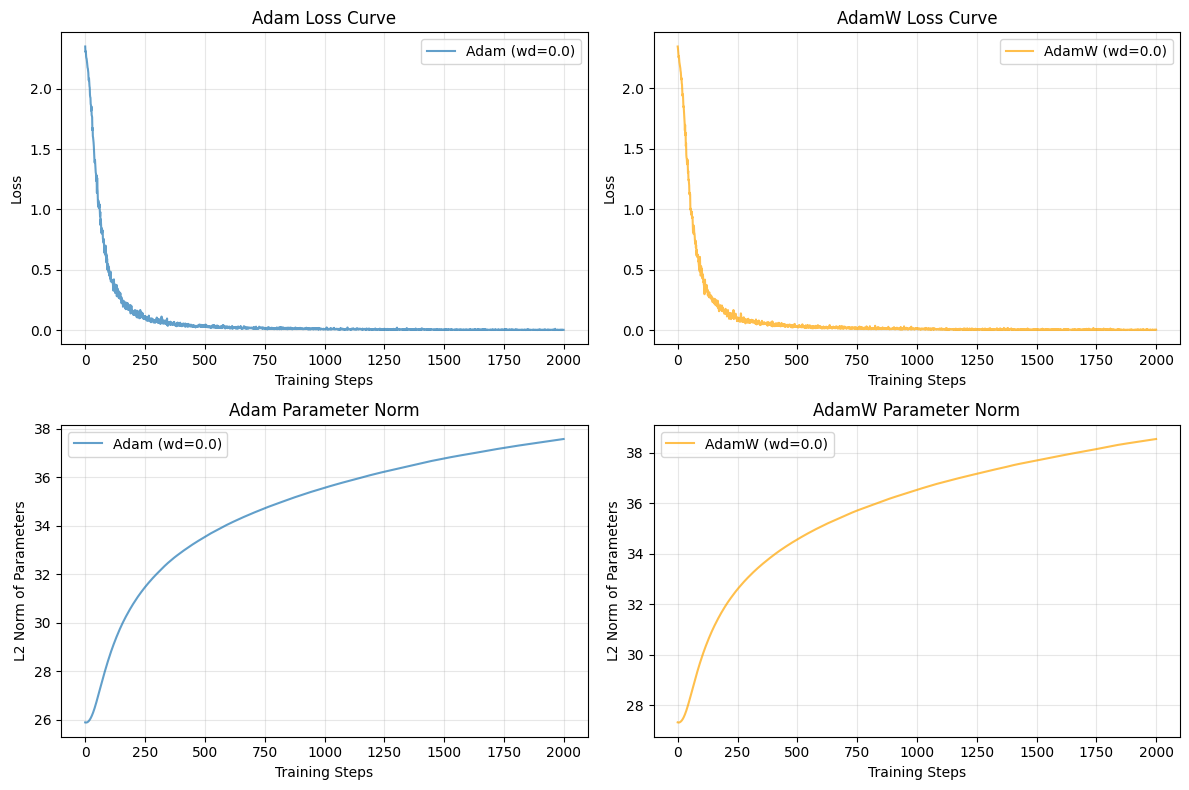


Final Results for wd=0.0:
Adam  - Final Loss: 0.0025, Final Norm: 37.5802
AdamW - Final Loss: 0.0033, Final Norm: 38.5463

Running experiment with weight_decay=0.01

Training with Adam...
Step 0/2000, Loss: 2.3511, Param Norm: 25.8731
Step 500/2000, Loss: 0.3790, Param Norm: 20.5812
Step 1000/2000, Loss: 0.3860, Param Norm: 17.7855
Step 1500/2000, Loss: 0.4186, Param Norm: 16.8569
Final - Loss: 0.4196, Param Norm: 16.5713

Training with AdamW...
Step 0/2000, Loss: 2.3471, Param Norm: 27.3239
Step 500/2000, Loss: 0.0317, Param Norm: 34.4523
Step 1000/2000, Loss: 0.0121, Param Norm: 36.3011
Step 1500/2000, Loss: 0.0029, Param Norm: 37.3489
Final - Loss: 0.0033, Param Norm: 38.0705


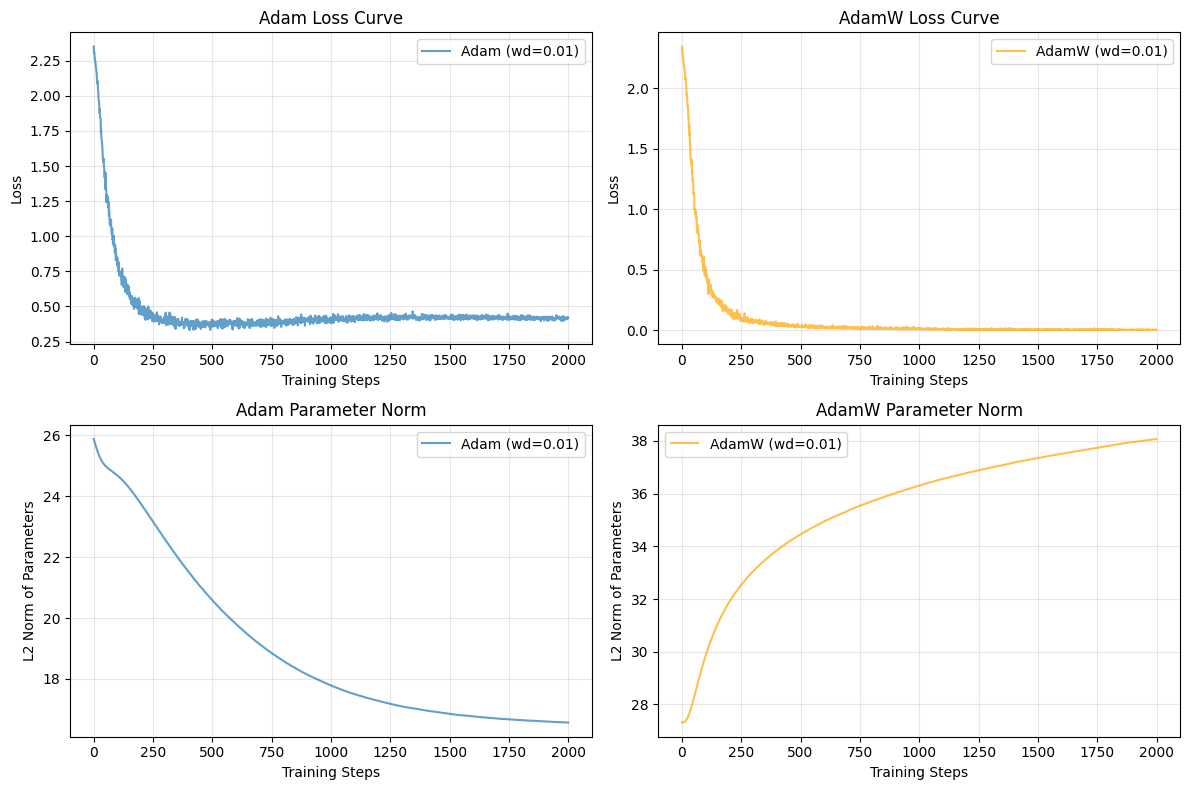


Final Results for wd=0.01:
Adam  - Final Loss: 0.4196, Final Norm: 16.5713
AdamW - Final Loss: 0.0033, Final Norm: 38.0705

Running experiment with weight_decay=0.1

Training with Adam...
Step 0/2000, Loss: 2.3511, Param Norm: 25.8460
Step 500/2000, Loss: 2.3030, Param Norm: 16.5479
Step 1000/2000, Loss: 2.3021, Param Norm: 11.0519
Step 1500/2000, Loss: 2.3028, Param Norm: 7.2487
Final - Loss: 2.3028, Param Norm: 4.6061

Training with AdamW...
Step 0/2000, Loss: 2.3471, Param Norm: 27.3215
Step 500/2000, Loss: 0.0357, Param Norm: 33.4380
Step 1000/2000, Loss: 0.0152, Param Norm: 34.4026
Step 1500/2000, Loss: 0.0044, Param Norm: 34.6413
Final - Loss: 0.0037, Param Norm: 34.6279


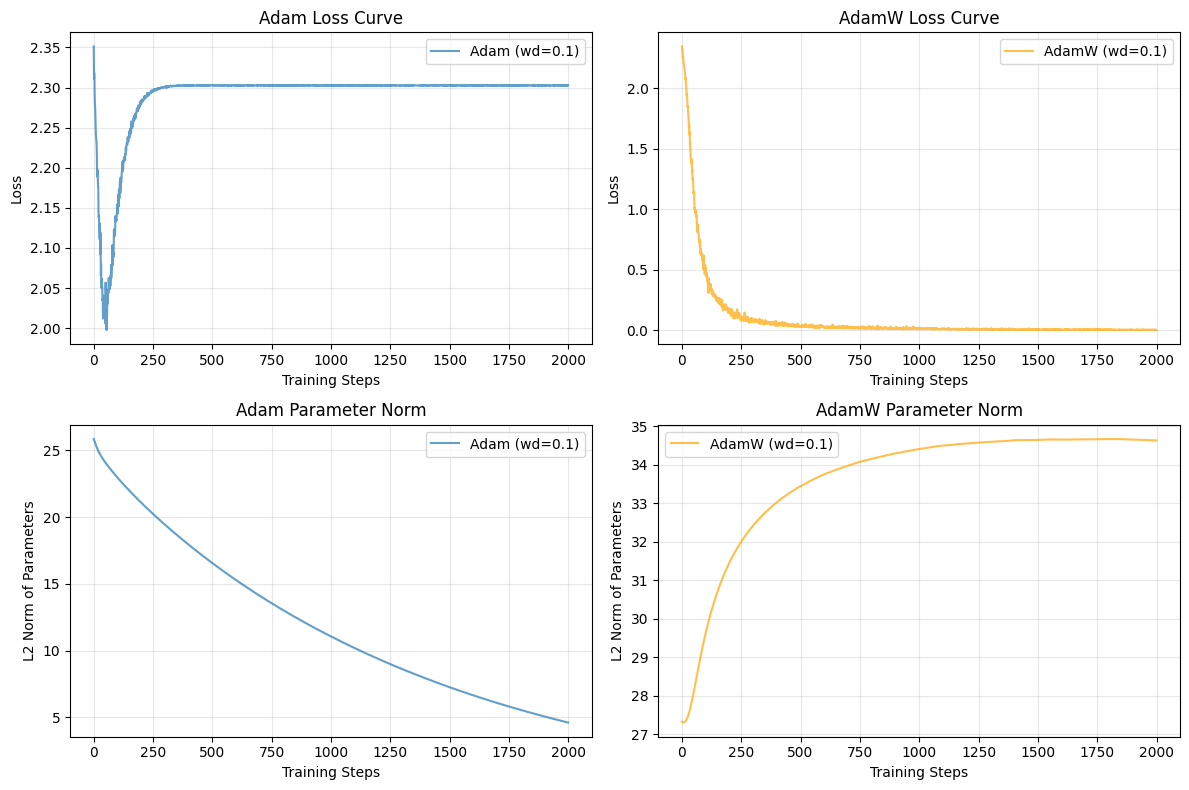


Final Results for wd=0.1:
Adam  - Final Loss: 2.3028, Final Norm: 4.6061
AdamW - Final Loss: 0.0037, Final Norm: 34.6279


In [5]:
# Option 2: Full experiment (test different weight decay values)
results = run_experiment(wd_values=[0.0, 0.01, 0.1], steps=2000, use_mlp=True)

Using device: cuda

Running experiment with weight_decay=0.01

Training with Adam...
Step 0/1500, Loss: 2.4477, Param Norm: 26.0006
Step 500/1500, Loss: 1.9464, Param Norm: 15.4666
Step 1000/1500, Loss: 1.8772, Param Norm: 11.6506
Final - Loss: 1.8902, Param Norm: 9.3441

Training with AdamW...
Step 0/1500, Loss: 2.3617, Param Norm: 25.8092
Step 500/1500, Loss: 1.7041, Param Norm: 27.2469
Step 1000/1500, Loss: 0.0017, Param Norm: 28.4188
Final - Loss: 0.0007, Param Norm: 28.4315


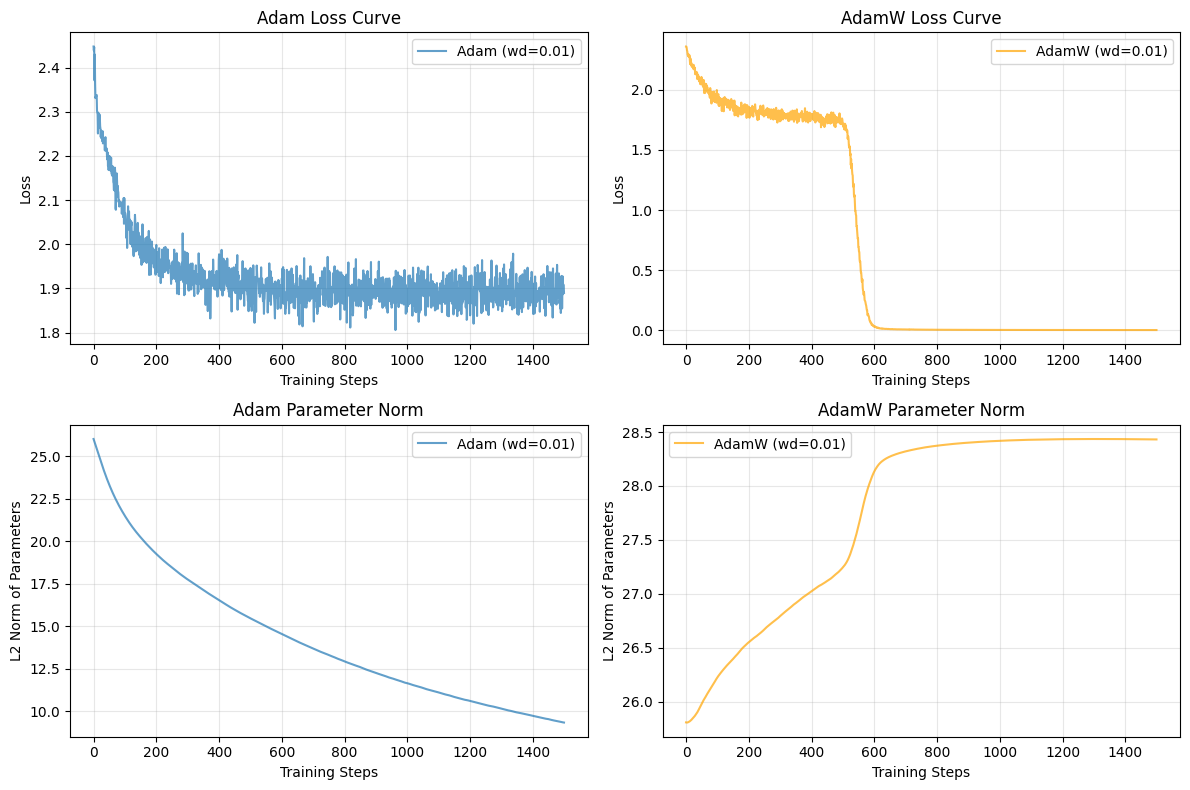


Final Results for wd=0.01:
Adam  - Final Loss: 1.8902, Final Norm: 9.3441
AdamW - Final Loss: 0.0007, Final Norm: 28.4315


In [6]:
# Option 3: Use Transformer model (slower but more realistic)
results = run_experiment(wd_values=[0.01], steps=1500, use_mlp=False)